## Import packages

In [1]:
library(devtools)
library(ggridges)
library(dplyr)
library(tidyr)
library(ggplot2)
library(quantmod)
library(xts)
library(zoo)
library(gridExtra)
library(tibble)
library(grid)
library(future)
library(future.apply)
library(DescTools)
library(rcompanion)
library(tidyverse)

Loading required package: usethis


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



######################### Warning from 'xts' package ##########################
#                                                                             #
# The dplyr lag() function breaks how base R's lag() function is supposed to  #
# work, which breaks lag(my_xts). Calls to lag(my_xts) that you type or       #
# source() into this session won't work correctly.                            #
#                                                                             #
# Use stats::lag() to make sure you're not using dplyr::lag(), or you can add #
# conflictRules('dplyr', ex

ERROR: Error in library(DescTools): there is no package called ‘DescTools’


In [2]:
source("forecast_research/finance/markets_functions.R")


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [3]:
load_all("forecast_research/vendor/hmmTMB")

ℹ Loading hmmTMB
Loading required package: R6

Loading required package: mgcv

Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.

Loading required package: TMB



In [4]:
remotes::install_local("/project/6004619/dcs01/forecast_research/vendor/hmmTMB", force = TRUE)


── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/Rtmpic2w2w/file6d0727e64889a/hmmTMB/DESCRIPTION’ ... OK
* preparing ‘hmmTMB’:
* checking DESCRIPTION meta-information ... OK
* cleaning src
'
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
  NB: this package now depends on R (>= 3.5.0)
  serialize/load version 3 cannot be read in older versions of R.
  File(s) containing such objects:
    ‘hmmTMB/inst/devel/test_data/simulated_pdfs.rds’
    ‘hmmTMB/inst/devel/test_data/simulated_runs.rds’
'
* building ‘hmmTMB_1.1.0.tar.gz’



Installing package into ‘/home/dcs01/R/x86_64-pc-linux-gnu-library/4.5’
(as ‘lib’ is unspecified)



In [80]:
options(warn = -1)

## Import close data

Warning message:
“CL=F contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them.”
Warning message:
“GC=F contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them.”
Warning message:
“HG=F contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them.”
Warning message:
“CAD=X contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them.”
Dropping columns with NA fraction > 0.15: Canada_Utilities_Index, Canada_Consumer_Staples_Index, Canada_Health_

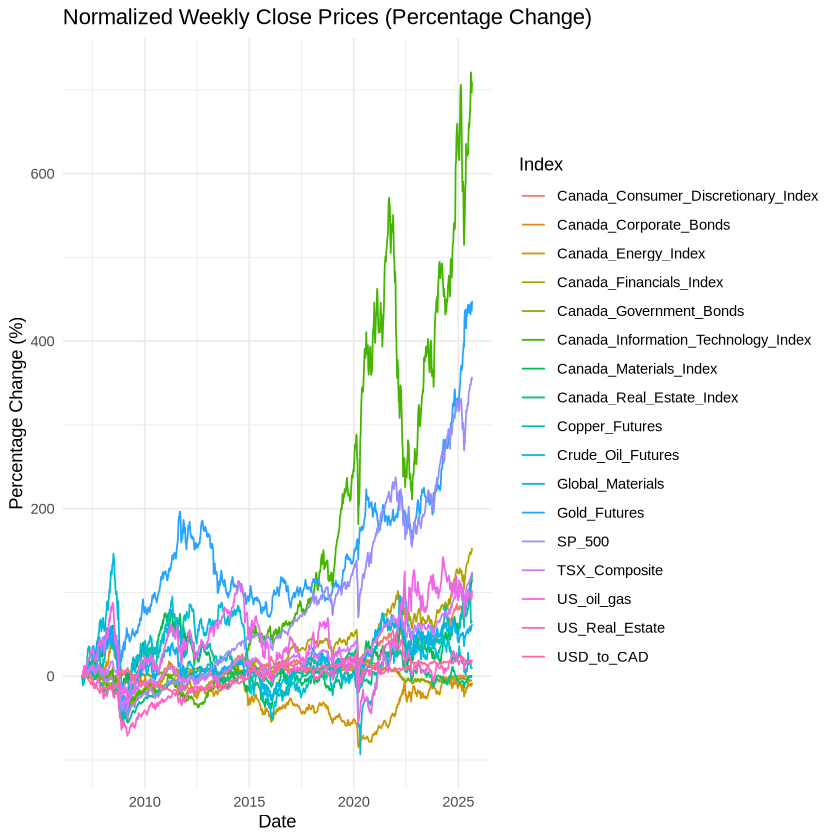

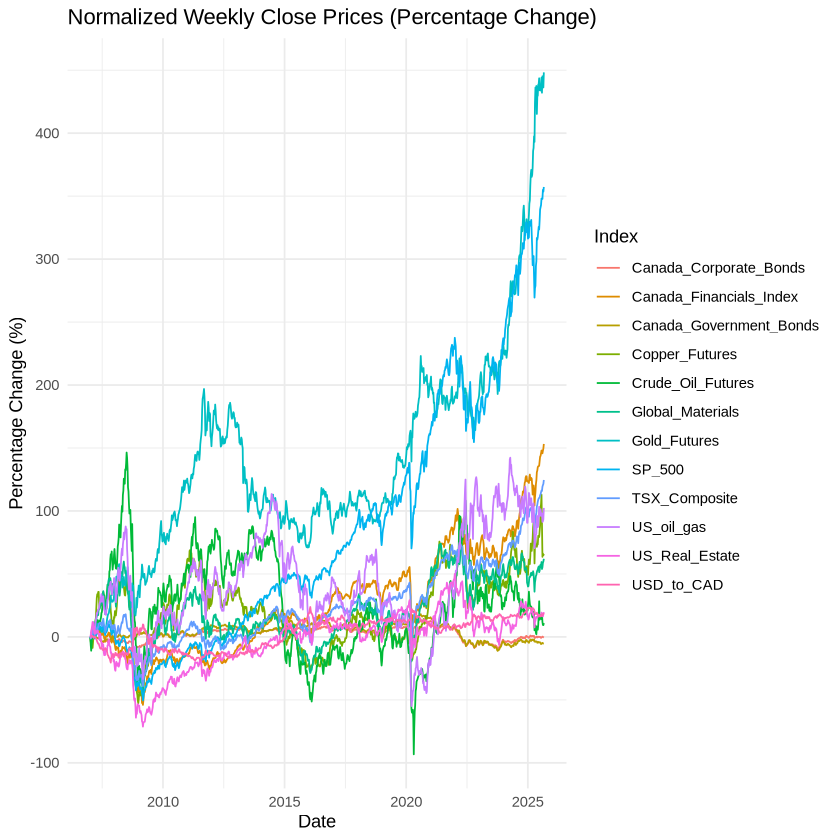

In [5]:
close_data <- get_markets_data("2007-01-01", "2025-09-01", "weeks", plot=TRUE)

close_data <- close_data %>%
  select(Date, 
    TSX_Composite, Canada_Financials_Index,
    Crude_Oil_Futures, Gold_Futures, Copper_Futures,
    USD_to_CAD, Canada_Corporate_Bonds,
    Canada_Government_Bonds, US_oil_gas, Global_Materials,
    US_Real_Estate, SP_500,
  )

close_data_log <- ln_transform(close_data)

# Reshape data for ggplot
close_data_long <- close_data %>%
  pivot_longer(-Date, names_to = "Index", values_to = "Close") %>%
  group_by(Index) %>%
  mutate(Close = (Close / first(Close) - 1) * 100)

# Plot using ggplot2
ggplot(close_data_long, aes(x = Date, y = Close, color = Index)) +
  geom_line() +
  labs(title = "Normalized Weekly Close Prices (Percentage Change)", x = "Date", y = "Percentage Change (%)") +
  theme_minimal()

In [87]:
# Fit HMM with covariates on train
evaluate_model <- function(train, test, combined, formula) {
  train_size <- nrow(train)
  test_size  <- nrow(test)
  
  hmm <- fit_hmm(
    data        = train,
    obs_name    = obs_name,
    n_states    = n_states,
    hid_formula = formula,
    horseshoe   = FALSE
  )
  forecast <- Forecast$new(
    hmm                        = hmm,
    forecast_data              = test,
    starting_state_distribution = "last",
    preset_eval_range          = setNames(list(eval_range), obs_name)
  )
  true_model <- fit_hmm(
    data        = combined,
    obs_name    = obs_name,
    n_states    = n_states,
    hid_formula = formula,
    horseshoe   = FALSE,
    init        = hmm
  )

  # -- State forecast log-loss --
  forecast_states <- matrix(
    forecast$hidden_state_forecast(),
    ncol = n_states,
    byrow = TRUE
  )
  true_states <- true_model$state_probs()[
    (train_size - test_size + 1):train_size,
    ,
    drop = FALSE
  ]
  print(paste("true_states dim:", dim(true_states)))
  print(paste("forecast_states dim:", dim(forecast_states)))
  state_cross_entropy <- -rowSums(true_states * log(forecast_states + 1e-10))

  # --- Prediction log-loss ---
  forecast_dists <- forecast$forecast_dists()[[obs_name]]
  eval_range_loc <- forecast$eval_range()[[obs_name]]

  prediction_loss <- numeric(test_size)
  for (j in seq_len(test_size)) {
    pdf_val <- tryCatch(
      {
        val <- approx(
          x    = eval_range_loc,
          y    = forecast_dists[, j],
          xout = test[[obs_name]][j]
        )$y
        if (is.na(val)) 1e-10 else val
      },
      error = function(e) 1e-10
    )
    prediction_loss[j] <- -log(pdf_val)
  }

  list(
    state_forecast     = forecast_states,
    true_states        = true_states,
    state_logloss      = state_cross_entropy,
    prediction_logloss = prediction_loss,
    hmm                = hmm,
    forecast           = forecast
  )
}

In [88]:
compute_cov_loss <- function(samples, obs_name, cov_name, n_states, eval_range) {
  # Number of time series samples
  n_series   <- length(samples$train)

  series     <- vector("list", n_series)

  train_size <- nrow(samples$train[[1]])
  test_size  <- nrow(samples$test[[1]])

  for (i in seq_len(n_series)) {
    train_sample <- samples$train[[i]]
    test_sample  <- samples$test[[i]]

    # 1) Fit HMM on the covariate alone
    if (!is.null(cov_name)) {
      covariate <- fit_hmm(
        data        = train_sample,
        obs_name    = cov_name,
        n_states    = n_states,
        hid_formula = ~ 1,
        horseshoe   = FALSE
      )

      cov_states <- covariate$state_probs()
      colnames(cov_states) <- paste0(cov_name, "_State_", seq_len(n_states))

      # Formula: obs ~ 1 + cov_name_State_1 + ... + cov_name_State_K
      formula <- as.formula(
        paste0(" ~ 1 + ", paste(colnames(cov_states), collapse = " + "))
      )
    } else {
      cov_states <- matrix(NA, nrow = train_size, ncol = 1)
      formula <- as.formula(" ~ 1")
    }

    # 2) Build covariate design data using lead(obs) and covariate states
    obs_train <- dplyr::lead(train_sample[[obs_name]], n = test_size)

    # Build a proper data.frame with the obs column named obs_name
    cov_data <- data.frame(
      obs = obs_train,
      cov_states,
      check.names = FALSE
    )
    names(cov_data)[1] <- obs_name  # rename "obs" column to obs_name

    train <- as.data.frame(
      cov_data[1:(train_size - test_size), , drop = FALSE]
    )
    test  <- as.data.frame(
      cov_data[(train_size - test_size + 1):train_size, , drop = FALSE]
    )
    test[[obs_name]] <- test_sample[[obs_name]]
    combined <- rbind(train, test)
    print(paste("Evaluating series", i))
    series[[i]] <- list(
      cov_model = evaluate_model(train, test, combined, formula),
      tsx_model = evaluate_model(train, test, combined, ~ 1)
    )
  }
  series
}


In [115]:
train_cutoff <- as.Date("2020-01-01")
train_size <- which.min(abs(close_data$Date - train_cutoff))
max_test_size <- 25
n_samples <- 25
n_states <- 3
eval_range <- seq(from = -0.2, to = 0.2, by = 0.001)
obs_name <- "TSX_Composite"
cov_name <- "Gold_Futures"
log_data <- ln_transform(close_data)

In [116]:
library(parallel)

n_cores    <- as.integer(Sys.getenv("SLURM_CPUS_PER_TASK", "1"))
test_sizes <- seq_len(max_test_size)

parallel_fun <- function(test_size) {
  samples <- train_test_split(
    log_data,
    training_period = train_size,
    testing_period  = test_size,
    samples         = n_samples
  )
  print(paste("iteration", test_size))
  compute_cov_loss(samples, obs_name, cov_name, n_states, eval_range)
}

results <- mclapply(
  test_sizes,
  parallel_fun,
  mc.cores    = n_cores,
  mc.set.seed = TRUE
)


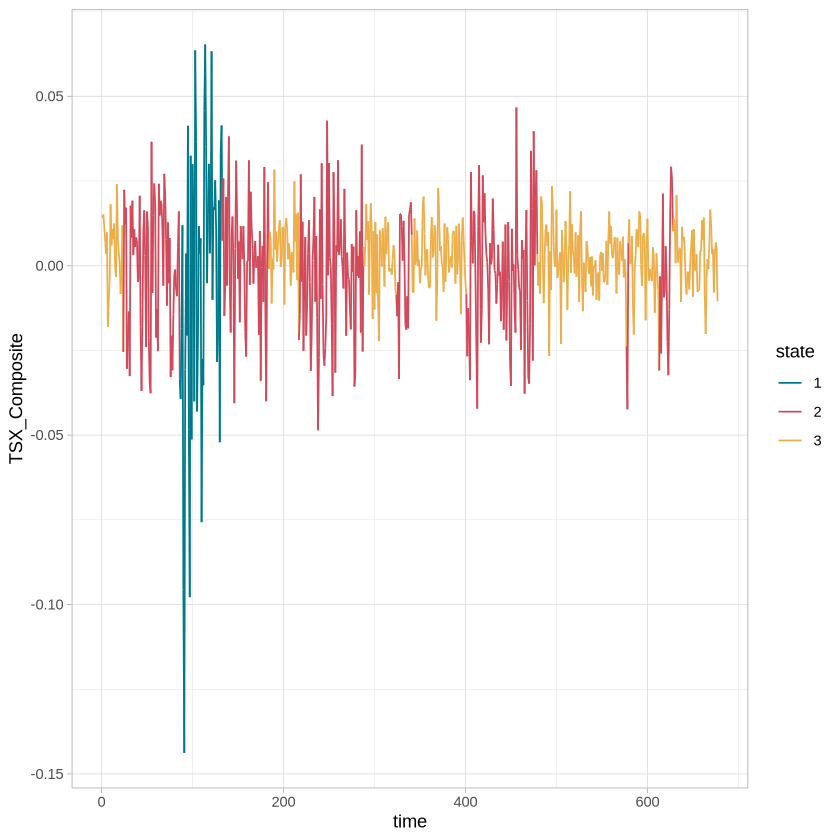

In [114]:
results[[2]][[1]]$tsx_model$hmm$plot_ts("TSX_Composite")

In [100]:
results[[2]][[1]]$cov_model$forecast$hidden_state_forecast()

[,1] [,2]
[1,] NaN  NaN 
[2,] NaN  NaN 
[3,] NaN  NaN

In [84]:
test_size <- 2
samples <- train_test_split(
  log_data,
  training_period = train_size,
  testing_period  = test_size,
  samples         = n_samples
)
compute_cov_loss(samples, obs_name, cov_name, n_states, eval_range)

[1] "Evaluating series 1"
[1] "true_states dim: 2" "true_states dim: 3"
[1] "forecast_states dim: 2" "forecast_states dim: 3"
[1] "true_states dim: 2" "true_states dim: 3"
[1] "forecast_states dim: 2" "forecast_states dim: 3"
[1] "Evaluating series 2"
[1] "true_states dim: 2" "true_states dim: 3"
[1] "forecast_states dim: 2" "forecast_states dim: 3"
[1] "true_states dim: 2" "true_states dim: 3"
[1] "forecast_states dim: 2" "forecast_states dim: 3"
[1] "Evaluating series 3"
[1] "true_states dim: 2" "true_states dim: 3"
[1] "forecast_states dim: 2" "forecast_states dim: 3"
[1] "true_states dim: 2" "true_states dim: 3"
[1] "forecast_states dim: 2" "forecast_states dim: 3"


[[1]]
[[1]]$cov_model
[[1]]$cov_model$state_forecast
     [,1] [,2] [,3]
[1,]  NaN  NaN  NaN
[2,]  NaN  NaN  NaN

[[1]]$cov_model$true_states
     state1 state2 state3
[1,]    NaN    NaN    NaN
[2,]    NaN    NaN    NaN

[[1]]$cov_model$state_logloss
[1] NaN NaN

[[1]]$cov_model$prediction_logloss
[1] 23.02585 23.02585


[[1]]$tsx_model
[[1]]$tsx_model$state_forecast
             [,1]      [,2]      [,3]
[1,] 0.0005055731 0.1391698 0.8603246
[2,] 0.0010008539 0.1687393 0.8302598

[[1]]$tsx_model$true_states
           state1     state2    state3
[1,] 3.471942e-06 0.02200330 0.9779932
[2,] 1.175364e-05 0.04302114 0.9569671

[[1]]$tsx_model$state_logloss
[1] 0.1905529 0.2546448

[[1]]$tsx_model$prediction_logloss
[1] -3.667372 -2.974397



[[2]]
[[2]]$cov_model
[[2]]$cov_model$state_forecast
             [,1]      [,2]       [,3]
[1,] 0.0005191589 0.9009565 0.09852433
[2,] 0.0008657414 0.8553375 0.14379673

[[2]]$cov_model$true_states
           state1    state2       state3
[1,] 5.325228e-05 0.9999369 9.890434e-06
[2,] 5.325664e-05 0.9860471 1.389964e-02

[[2]]$cov_model$state_logloss
[1] 0.1047174 0.1814107

[[2]]$cov_model$prediction_logloss
[1] -1.799916 -3.030399


[[2]]$tsx_model
[[2]]$tsx_model$state_forecast
             [,1]      [,2]       [,3]
[1,] 0.0003538815 0.9108663 0.08877981
[2,] 0.0005653060 0.8642133 0.13522136

[[2]]$tsx_model$true_states
           state1    state2       state3
[1,] 2.480665e-04 0.9997433 8.645318e-06
[2,] 9.383628e-05 0.9879241 1.198206e-02

[[2]]$tsx_model$state_logloss
[1] 0.09532738 0.16884925

[[2]]$tsx_model$prediction_logloss
[1] -1.819926 -3.030034



[[3]]
[[3]]$cov_model
[[3]]$cov_model$state_forecast
            [,1]       [,2]      [,3]
[1,] 0.002185654 0.06869906 0.9291153
[2,] 0.004408951 0.10317555 0.8924155

[[3]]$cov_model$true_states
           state1     state2    state3
[1,] 1.626741e-06 0.01058934 0.9894090
[2,] 7.366403e-06 0.01491353 0.9850791

[[3]]$cov_model$state_logloss
[1] 0.1011122 0.1460385

[[3]]$cov_model$prediction_logloss
[1] -3.730740 -3.021306


[[3]]$tsx_model
[[3]]$tsx_model$state_forecast
            [,1]       [,2]      [,3]
[1,] 0.002815426 0.08655304 0.9106315
[2,] 0.004802312 0.11948413 0.8757136

[[3]]$tsx_model$true_states
           state1     state2    state3
[1,] 2.592767e-05 0.01823542 0.9817387
[2,] 2.650385e-05 0.02036027 0.9796132

[[3]]$tsx_model$state_logloss
[1] 0.1366817 0.1734089

[[3]]$tsx_model$prediction_logloss
[1] -3.743482 -3.016197

In [83]:
results

[[1]]
[[1]][[1]]
[[1]][[1]]$cov_model
[[1]][[1]]$cov_model$state_forecast
     [,1]      [,2]      [,3]
[1,]    0 0.1223943 0.8776057

[[1]][[1]]$cov_model$true_states
     state1     state2   state3
[1,]      0 0.04362199 0.956378

[[1]][[1]]$cov_model$state_logloss
[1] 0.216491

[[1]][[1]]$cov_model$prediction_logloss
[1] -3.661693


[[1]][[1]]$tsx_model
[[1]][[1]]$tsx_model$state_forecast
             [,1]      [,2]      [,3]
[1,] 0.0004894606 0.1348219 0.8646887

[[1]][[1]]$tsx_model$true_states
           state1     state2    state3
[1,] 2.636261e-05 0.05289006 0.9470836

[[1]][[1]]$tsx_model$state_logloss
[1] 0.2438745

[[1]][[1]]$tsx_model$prediction_logloss
[1] -3.661916



[[1]][[2]]
[[1]][[2]]$cov_model
[[1]][[2]]$cov_model$state_forecast
             [,1]      [,2]       [,3]
[1,] 0.0004242649 0.9524128 0.04716295

[[1]][[2]]$cov_model$true_states
           state1    state2     state3
[1,] 8.698335e-05 0.9866527 0.01326029

[[1]][[2]]$cov_model$state_logloss
[1] 0.08928029

[[1]][[2]]$cov_model$prediction_logloss
[1] -2.990261


[[1]][[2]]$tsx_model
[[1]][[2]]$tsx_model$state_forecast
             [,1]      [,2]       [,3]
[1,] 0.0002046533 0.9334421 0.06635324

[[1]][[2]]$tsx_model$true_states
           state1    state2    state3
[1,] 6.443201e-05 0.9751742 0.0247614

[[1]][[2]]$tsx_model$state_logloss
[1] 0.1348855

[[1]][[2]]$tsx_model$prediction_logloss
[1] -2.966609



[[1]][[3]]
[[1]][[3]]$cov_model
[[1]][[3]]$cov_model$state_forecast
            [,1]      [,2]      [,3]
[1,] 0.002355122 0.0680592 0.9295857

[[1]][[3]]$cov_model$true_states
          state1    state2    state3
[1,] 0.000949771 0.0185581 0.9804921

[[1]][[3]]$cov_model$state_logloss
[1] 0.1272118

[[1]][[3]]$cov_model$prediction_logloss
[1] -3.080051


[[1]][[3]]$tsx_model
[[1]][[3]]$tsx_model$state_forecast
            [,1]       [,2]     [,3]
[1,] 0.002808399 0.07882863 0.918363

[[1]][[3]]$tsx_model$true_states
           state1     state2   state3
[1,] 8.183701e-05 0.03086521 0.969053

[[1]][[3]]$tsx_model$state_logloss
[1] 0.1614203

[[1]][[3]]$tsx_model$prediction_logloss
[1] -3.029249




[[2]]
[[2]][[1]]
[[2]][[1]]$cov_model
[[2]][[1]]$cov_model$state_forecast
     [,1] [,2] [,3]
[1,]  NaN  NaN  NaN
[2,]  NaN  NaN  NaN

[[2]][[1]]$cov_model$true_states
     state1 state2 state3
[1,]    NaN    NaN    NaN
[2,]    NaN    NaN    NaN

[[2]][[1]]$cov_model$state_logloss
[1] NaN NaN

[[2]][[1]]$cov_model$prediction_logloss
[1] 23.02585 23.02585


[[2]][[1]]$tsx_model
[[2]][[1]]$tsx_model$state_forecast
             [,1]      [,2]      [,3]
[1,] 0.0005055731 0.1391698 0.8603246
[2,] 0.0010008539 0.1687393 0.8302598

[[2]][[1]]$tsx_model$true_states
           state1     state2    state3
[1,] 3.471942e-06 0.02200330 0.9779932
[2,] 1.175364e-05 0.04302114 0.9569671

[[2]][[1]]$tsx_model$state_logloss
[1] 0.1905529 0.2546448

[[2]][[1]]$tsx_model$prediction_logloss
[1] -3.667372 -2.974397



[[2]][[2]]
[[2]][[2]]$cov_model
[[2]][[2]]$cov_model$state_forecast
             [,1]      [,2]       [,3]
[1,] 0.0005191589 0.9009565 0.09852433
[2,] 0.0008657414 0.8553375 0.14379673

[[2]][[2]]$cov_model$true_states
           state1    state2       state3
[1,] 5.325228e-05 0.9999369 9.890434e-06
[2,] 5.325664e-05 0.9860471 1.389964e-02

[[2]][[2]]$cov_model$state_logloss
[1] 0.1047174 0.1814107

[[2]][[2]]$cov_model$prediction_logloss
[1] -1.799916 -3.030399


[[2]][[2]]$tsx_model
[[2]][[2]]$tsx_model$state_forecast
             [,1]      [,2]       [,3]
[1,] 0.0003538815 0.9108663 0.08877981
[2,] 0.0005653060 0.8642133 0.13522136

[[2]][[2]]$tsx_model$true_states
           state1    state2       state3
[1,] 2.480665e-04 0.9997433 8.645318e-06
[2,] 9.383628e-05 0.9879241 1.198206e-02

[[2]][[2]]$tsx_model$state_logloss
[1] 0.09532738 0.16884925

[[2]][[2]]$tsx_model$prediction_logloss
[1] -1.819926 -3.030034



[[2]][[3]]
[[2]][[3]]$cov_model
[[2]][[3]]$cov_model$state_forecast
            [,1]       [,2]      [,3]
[1,] 0.002185654 0.06869906 0.9291153


In [76]:
test_sizes <- 5:6
lapply(
  test_sizes,
  parallel_fun
)


[1] "Evaluating series 1"
[1] "true_states dim: 6" "true_states dim: 3"
[1] "forecast_states dim: 5" "forecast_states dim: 3"


ERROR: Error in true_states * log(forecast_states + 1e-10): non-conformable arrays


In [75]:
test_size <- 6
samples <- train_test_split(
  log_data,
  training_period = train_size,
  testing_period  = test_size,
  samples         = n_samples
)
compute_cov_loss(samples, obs_name, cov_name, n_states, eval_range)

[1] "Evaluating series 1"
[1] "true_states dim: 6" "true_states dim: 3"
[1] "forecast_states dim: 6" "forecast_states dim: 3"
[1] "true_states dim: 6" "true_states dim: 3"
[1] "forecast_states dim: 6" "forecast_states dim: 3"
[1] "Evaluating series 2"
[1] "true_states dim: 6" "true_states dim: 3"
[1] "forecast_states dim: 6" "forecast_states dim: 3"
[1] "true_states dim: 6" "true_states dim: 3"
[1] "forecast_states dim: 6" "forecast_states dim: 3"
[1] "Evaluating series 3"
[1] "true_states dim: 6" "true_states dim: 3"
[1] "forecast_states dim: 6" "forecast_states dim: 3"
[1] "true_states dim: 6" "true_states dim: 3"
[1] "forecast_states dim: 6" "forecast_states dim: 3"


[[1]]
[[1]]$cov_model
[[1]]$cov_model$state_forecast
     [,1]      [,2]      [,3]
[1,]    0 0.1674325 0.8325675
[2,]    0 0.2022987 0.7977013
[3,]    0 0.2146560 0.7853440
[4,]    0 0.2262279 0.7737721
[5,]    0 0.2224536 0.7775464
[6,]    0 0.2131056 0.7868944

[[1]]$cov_model$true_states
     state1    state2    state3
[1,]      0 0.1674325 0.8325675
[2,]      0 0.2022987 0.7977013
[3,]      0 0.2146560 0.7853440
[4,]      0 0.2262279 0.7737721
[5,]      0 0.2224536 0.7775464
[6,]      0 0.2131056 0.7868944

[[1]]$cov_model$state_logloss
[1] 0.4517917 0.5035726 0.5200605 0.5346782 0.5299959 0.5180424

[[1]]$cov_model$prediction_logloss
[1] -3.634709 -2.943591 -3.392193 -3.143568 -3.559720 -3.115152


[[1]]$tsx_model
[[1]]$tsx_model$state_forecast
             [,1]      [,2]      [,3]
[1,] 0.0004971804 0.1380272 0.8614756
[2,] 0.0009872038 0.1679855 0.8310273
[3,] 0.0015737078 0.1951994 0.8032269
[4,] 0.0022442002 0.2199182 0.7778376
[5,] 0.0029874191 0.2423681 0.7546445
[6,] 0.0037932187 0.2627553 0.7334515

[[1]]$tsx_model$true_states
           state1    state2    state3
[1,] 0.0004971804 0.1380272 0.8614756
[2,] 0.0009872038 0.1679855 0.8310273
[3,] 0.0015737078 0.1951994 0.8032269
[4,] 0.0022442002 0.2199182 0.7778376
[5,] 0.0029874191 0.2423681 0.7546445
[6,] 0.0037932187 0.2627553 0.7334515

[[1]]$tsx_model$state_logloss
[1] 0.4055711 0.4603146 0.5050626 0.5421763 0.5733135 0.5996918

[[1]]$tsx_model$prediction_logloss
[1] -3.662891 -2.953941 -3.409647 -3.133643 -3.555349 -3.097965



[[2]]
[[2]]$cov_model
[[2]]$cov_model$state_forecast
            [,1]      [,2]       [,3]
[1,] 0.001402802 0.9322553 0.06634193
[2,] 0.001589639 0.8765140 0.12189632
[3,] 0.001941673 0.8293483 0.16871006
[4,] 0.002395597 0.7872646 0.21033977
[5,] 0.002845474 0.7483791 0.24877547
[6,] 0.003358617 0.7305271 0.26611426

[[2]]$cov_model$true_states
          state1    state2     state3
[1,] 0.001402802 0.9322553 0.06634193
[2,] 0.001589639 0.8765140 0.12189632
[3,] 0.001941673 0.8293483 0.16871006
[4,] 0.002395597 0.7872646 0.21033977
[5,] 0.002845474 0.7483791 0.24877547
[6,] 0.003358617 0.7305271 0.26611426

[[2]]$cov_model$state_logloss
[1] 0.2545930 0.3823119 0.4675398 0.5306880 0.5796922 0.6007988

[[2]]$cov_model$prediction_logloss
[1] -3.056961 -2.776299 -3.034037 -3.050896 -3.205829 -2.930993


[[2]]$tsx_model
[[2]]$tsx_model$state_forecast
             [,1]      [,2]       [,3]
[1,] 0.0007820203 0.9377685 0.06144948
[2,] 0.0008420817 0.8855606 0.11359727
[3,] 0.0010449376 0.8386898 0.16026522
[4,] 0.0013528989 0.7966267 0.20202043
[5,] 0.0017356623 0.7588917 0.23937263
[6,] 0.0021690201 0.7250511 0.27277984

[[2]]$tsx_model$true_states
           state1    state2     state3
[1,] 0.0007820203 0.9377685 0.06144948
[2,] 0.0008420817 0.8855606 0.11359727
[3,] 0.0010449376 0.8386898 0.16026522
[4,] 0.0013528989 0.7966267 0.20202043
[5,] 0.0017356623 0.7588917 0.23937263
[6,] 0.0021690201 0.7250511 0.27277984

[[2]]$tsx_model$state_logloss
[1] 0.2372637 0.3606726 0.4481434 0.5131736 0.5626470 0.6007827

[[2]]$tsx_model$prediction_logloss
[1] -3.013391 -2.746291 -2.997414 -3.029433 -3.169828 -2.913037



[[3]]
[[3]]$cov_model
[[3]]$cov_model$state_forecast
             [,1]       [,2]      [,3]
[1,] 1.321350e-02 0.05911847 0.9276680
[2,] 1.422137e-02 0.08764936 0.8981293
[3,] 2.595245e-04 0.12994195 0.8697985
[4,] 6.498016e-07 0.15951052 0.8404888
[5,] 4.070743e-06 0.18674335 0.8132526
[6,] 6.423913e-06 0.21194737 0.7880462

[[3]]$cov_model$true_states
           state1     state2    state3
[1,] 1.321350e-02 0.05911847 0.9276680
[2,] 1.422137e-02 0.08764936 0.8981293
[3,] 2.595245e-04 0.12994195 0.8697985
[4,] 6.498016e-07 0.15951052 0.8404888
[5,] 4.070743e-06 0.18674335 0.8132526
[6,] 6.423913e-06 0.21194737 0.7880462

[[3]]$cov_model$state_logloss
[1] 0.2940185 0.3703544 0.3886425 0.4388671 0.4815199 0.5166071

[[3]]$cov_model$prediction_logloss
[1] -3.624201 -2.998000 -3.407403 -3.160849 -3.529506 -3.128097


[[3]]$tsx_model
[[3]]$tsx

In [98]:
test_sizes <- 1:2

nonCov_loss_serial <- vector("list", length(test_sizes))
cov_loss_serial    <- vector("list", length(test_sizes))

for (i in seq_along(test_sizes)) {
  test_size <- test_sizes[i]
  samples <- train_test_split(
    ln_transform(close_data),
    training_period = train_size,
    testing_period  = test_size,
    samples         = n_samples
  )
  nonCov_loss_serial[[i]] <- compute_nonCov_loss(samples, obs_name, n_states, eval_range)
  cov_loss_serial[[i]]    <- compute_cov_loss(samples, obs_name, cov_name, n_states, eval_range)
}

Warning message in hmm$fit(silent = TRUE):
“Convergence code was not zero, indicating that the optimizer may not have converged to the correct estimates. Please check by consulting the out() function which shows what nlminb returned.”
Warning message in hmm$fit(silent = TRUE):
“Convergence code was not zero, indicating that the optimizer may not have converged to the correct estimates. Please check by consulting the out() function which shows what nlminb returned.”
Warning message in hmm$fit(silent = TRUE):
“Convergence code was not zero, indicating that the optimizer may not have converged to the correct estimates. Please check by consulting the out() function which shows what nlminb returned.”
Warning message in nlminb(start = args$par, objective = args$fn, gradient = args$gr, :
“NA/NaN function evaluation”
Warning message in nlminb(start = args$par, objective = args$fn, gradient = args$gr, :
“NA/NaN function evaluation”
Warning message in nlminb(start = args$par, objective = args$fn

In [100]:
cov_loss_serial[[2]]

$state_logloss
$state_logloss[[1]]
[1] NaN NaN

$state_logloss[[2]]
[1] -1e-10 -1e-10

$state_logloss[[3]]
[1] 0.7675499 0.7882415

$state_logloss[[4]]
[1] 0.5326954 0.5086172

$state_logloss[[5]]
[1] 0.7139525 0.7439906

$state_logloss[[6]]
[1] 0.6862933 0.6713211

$state_logloss[[7]]
[1] 0.08824677 0.08213300

$state_logloss[[8]]
[1] 0.1601953 0.2215757

$state_logloss[[9]]
[1] 0.3540377 0.4103428

$state_logloss[[10]]
[1] 0.4845028 0.5806450

$state_logloss[[11]]
[1] 0.2307005 0.2731268

$state_logloss[[12]]
[1] 0.4933192 0.5613081

$state_logloss[[13]]
[1] 0.1697396 0.4127895

$state_logloss[[14]]
[1] 0.5368903 0.6132695

$state_logloss[[15]]
[1] 0.7012323 0.7513814

$state_logloss[[16]]
[1] 0.4049200 0.4550163

$state_logloss[[17]]
[1] 0.03879551 0.11090318

$state_logloss[[18]]
[1] 0.2237130 0.3102524

$state_logloss[[19]]
[1] 0.2113184 0.7482527

$state_logloss[[20]]
[1] 0.4106915 0.5095824

$state_logloss[[21]]
[1] 0.6772547 0.6827714

$state_logloss[[22]]
[1] 0.3795246 0.7003732

$state_logloss[[23]]
[1] 1.099448 1.198497

$state_logloss[[24]]
[1] 0.8274851 0.7859539

$state_logloss[[25]]
[1] 0.1344795 0.2239219


$prediction_logloss
$prediction_logloss[[1]]
[1] 23.02585 23.02585

$prediction_logloss[[2]]
[1] -1.573762 -1.102344

$prediction_logloss[[3]]
[1] -2.973453 -3.320018

$prediction_logloss[[4]]
[1] -3.358469 -1.941740

$prediction_logloss[[5]]
[1] -2.828772 -3.174798

$prediction_logloss[[6]]
[1] -1.997734 -3.162108

$prediction_logloss[[7]]
[1] -3.456030 -3.676437

$prediction_logloss[[8]]
[1] -3.425149 -3.634233

$prediction_logloss[[9]]
[1] -3.724296 -2.860627

$prediction_logloss[[10]]
[1] -2.984097 -2.997281

$prediction_logloss[[11]]
[1]  0.0395533 -2.6490246

$prediction_logloss[[12]]
[1] -2.764852 -2.709970

$prediction_logloss[[13]]
[1] -1.799916 -3.030399

$prediction_logloss[[14]]
[1] -2.588492 -2.881192

$prediction_logloss[[15]]
[1] -2.897196 -3.014394

$prediction_logloss[[16]]
[1] -3.660590 -2.529031

$prediction_logloss[[17]]
[1] -2.420430 -2.296281

$prediction_logloss[[18]]
[1] -3.561071 -3.279628

$prediction_logloss[[19]]
[1] -3.721955 -3.262626

$prediction_logloss[[20]]
[1] -2.736758 -2.509865

$prediction_logloss[[21]]
[1] -2.915753 -2.077429

$prediction_logloss[[22]]
[1] -2.984318 -3.114504

$prediction_logloss[[23]]
[1] -2.795700 -1.444932

$prediction_logloss[[24]]
[1] -3.287894 -3.070781

$prediction_logloss[[25]]
[1] -3.730740 -3.021306

In [65]:
mapply(function(x, y) y - x, 
  nonCov_loss_serial[[1]]$state_logloss[3:25], 
  cov_loss_serial[[1]]$state_logloss[3:25], 
  SIMPLIFY = FALSE)

[[1]]
[1] -0.03735988

[[2]]
[1] 0.1069575

[[3]]
[1] -0.01276104

[[4]]
[1] -0.01100092

[[5]]
[1] -0.08223453

[[6]]
[1] -0.0191496

[[7]]
[1] -0.184504

[[8]]
[1] 0.1067359

[[9]]
[1] 0.06056114

[[10]]
[1] 0.03820926

[[11]]
[1] -0.1042821

[[12]]
[1] 0.03205527

[[13]]
[1] -0.06070005

[[14]]
[1] -0.0403345

[[15]]
[1] -0.06507477

[[16]]
[1] -0.06217014

[[17]]
[1] -0.09808251

[[18]]
[1] -0.004626025

[[19]]
[1] 0.2235838

[[20]]
[1] -0.03509204

[[21]]
[1] -0.2979061

[[22]]
[1] -0.7204663

[[23]]
[1] -0.03831836

In [53]:
cov_loss_serial

[[1]]
[[1]]$state_logloss
[[1]]$state_logloss[[1]]
[1] 0.2454248

[[1]]$state_logloss[[2]]
[1] NaN

[[1]]$state_logloss[[3]]
[1] 0.6026175

[[1]]$state_logloss[[4]]
[1] 0.7765495

[[1]]$state_logloss[[5]]
[1] 0.7046917

[[1]]$state_logloss[[6]]
[1] 0.7674498

[[1]]$state_logloss[[7]]
[1] 0.1569356

[[1]]$state_logloss[[8]]
[1] 0.2116036

[[1]]$state_logloss[[9]]
[1] 0.2030724

[[1]]$state_logloss[[10]]
[1] 0.5284313

[[1]]$state_logloss[[11]]
[1] 0.2739588

[[1]]$state_logloss[[12]]
[1] 0.4347846

[[1]]$state_logloss[[13]]
[1] 0.3147205

[[1]]$state_logloss[[14]]
[1] 0.627713

[[1]]$state_logloss[[15]]
[1] 0.6545247

[[1]]$state_logloss[[16]]
[1] 0.37777

[[1]]$state_logloss[[17]]
[1] 0.05847643

[[1]]$state_logloss[[18]]
[1] 0.3098345

[[1]]$state_logloss[[19]]
[1] 0.08011238

[[1]]$state_logloss[[20]]
[1] 0.5660049

[[1]]$state_logloss[[21]]
[1] 0.7381967

[[1]]$state_logloss[[22]]
[1] 0.2321044

[[1]]$state_logloss[[23]]
[1] 0.7850355

[[1]]$state_logloss[[24]]
[1] 0.00798693

[[1]]$state_logloss[[25]]
[1] 0.1923177


[[1]]$prediction_logloss
[[1]]$prediction_logloss[[1]]
[1] -3.661693

[[1]]$prediction_logloss[[2]]
[1] 23.02585

[[1]]$prediction_logloss[[3]]
[1] -2.975779

[[1]]$prediction_logloss[[4]]
[1] -3.2992

[[1]]$prediction_logloss[[5]]
[1] -3.214032

[[1]]$prediction_logloss[[6]]
[1] -1.991081

[[1]]$prediction_logloss[[7]]
[1] -3.455275

[[1]]$prediction_logloss[[8]]
[1] -3.42027

[[1]]$prediction_logloss[[9]]
[1] -2.855534

[[1]]$prediction_logloss[[10]]
[1] -2.983667

[[1]]$prediction_logloss[[11]]
[1] -0.01705087

[[1]]$prediction_logloss[[12]]
[1] -2.773107

[[1]]$prediction_logloss[[13]]
[1] -2.990261

[[1]]$prediction_logloss[[14]]
[1] -2.899721

[[1]]$prediction_logloss[[15]]
[1] -3.044533

[[1]]$prediction_logloss[[16]]
[1] -3.662371

[[1]]$prediction_logloss[[17]]
[1] -2.368559

[[1]]$prediction_logloss[[18]]
[1] -3.311901

[[1]]$prediction_logloss[[19]]
[1] -3.661041

[[1]]$prediction_logloss[[20]]
[1] -2.499921

[[1]]$prediction_logloss[[21]]
[1] -1.987075

[[1]]$prediction_logloss[[22]]
[1] -3.271438

[[1]]$prediction_logloss[[23]]
[1] -1.071165

[[1]]$prediction_logloss[[24]]
[1] -2.837028

[[1]]$prediction_logloss[[25]]
[1] -3.080051

In [29]:
.libPaths()
find.package("hmmTMB")

[1] "/home/dcs01/R/x86_64-pc-linux-gnu-library/4.5"                                                          
[2] "/cvmfs/soft.computecanada.ca/easybuild/software/2023/x86-64-v4/Compiler/gcccore/r/4.5.0/lib64/R/library"

[1] "/project/6004619/dcs01/forecast_research/vendor/hmmTMB"

In [30]:
install.packages("remotes")  # if needed
remotes::install_local("/project/6004619/dcs01/forecast_research/vendor/hmmTMB")

Installing package into ‘/home/dcs01/R/x86_64-pc-linux-gnu-library/4.5’
(as ‘lib’ is unspecified)



S7      (0.2.0 -> 0.2.1) [CRAN]
ggplot2 (4.0.0 -> 4.0.1) [CRAN]


Installing 2 packages: S7, ggplot2

Installing packages into ‘/home/dcs01/R/x86_64-pc-linux-gnu-library/4.5’
(as ‘lib’ is unspecified)



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpAleaBV/file4413653cf27d4/hmmTMB/DESCRIPTION’ ... OK
* preparing ‘hmmTMB’:
* checking DESCRIPTION meta-information ... OK
* cleaning src
'
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
  NB: this package now depends on R (>= 3.5.0)
  serialize/load version 3 cannot be read in older versions of R.
  File(s) containing such objects:
    ‘hmmTMB/inst/devel/test_data/simulated_pdfs.rds’
    ‘hmmTMB/inst/devel/test_data/simulated_runs.rds’
'
* building ‘hmmTMB_1.1.0.tar.gz’



Installing package into ‘/home/dcs01/R/x86_64-pc-linux-gnu-library/4.5’
(as ‘lib’ is unspecified)

